In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn.feature_map import ChebRx
from squlearn.expectation_operator import SummedPaulis
from squlearn.qnn.loss import SquaredLoss
from squlearn.qnn.qnnc import QNNClassifier
from squlearn.optimizers import SLSQP
from squlearn.util import Executor

In [2]:
executor = Executor("statevector_simulator")

Define parameterized quantum circuit $Q(x,\theta)$

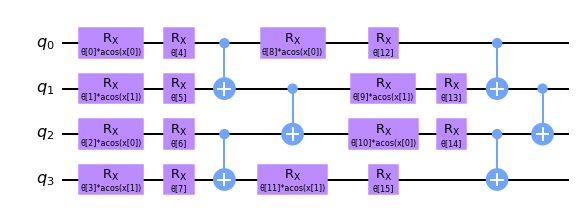

In [3]:
nqubits = 4

number_of_layers = 2
pqc = ChebRx(nqubits, 2, num_layers=number_of_layers)
pqc.draw()

Definition of the cost operator:

In [4]:
cost_op = SummedPaulis(nqubits)
print(cost_op)

SummedOp([
  1.0*p[0] * IIII,
  1.0*p[1] * IIIZ,
  1.0*p[2] * IIZI,
  1.0*p[3] * IZII,
  1.0*p[4] * ZIII
])


In [5]:
np.random.seed(24)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(cost_op.num_parameters)

clf = QNNClassifier(pqc, cost_op, executor, SquaredLoss, SLSQP(), param_ini, param_op_ini)

### Generate Dataset

In [6]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = make_blobs(60, centers=2, random_state=0)
X = MinMaxScaler((-0.9, 0.9)).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Optimization of the classifier

In [7]:
clf.fit(X_train, y_train)

theta [0.9600173  0.69951205 0.99986729 0.2200673  0.36105635 0.73984099
 0.99645573 0.31634698 0.13654458 0.38398001 0.32051928 0.36641475
 0.70965156 0.90014243 0.53411544 0.24729376 0.67180656 0.56172911
 0.54255988 0.8934476  0.84277955]
Current value: 9.71927312384981
theta [0.9600173  0.69951205 0.99986729 0.2200673  0.36105635 0.73984099
 0.99645573 0.31634698 0.13654458 0.38398001 0.32051928 0.36641475
 0.70965156 0.90014243 0.53411544 0.24729376 0.67180656 0.56172911
 0.54255988 0.8934476  0.84277955]
Grad length: 27.193747233457714
grad [  7.40887932  -1.03872944   8.41486501   1.30092729   5.21614322
  -0.72616256   5.88689548   0.69420498   6.89999731  -7.67574739
   6.42574244   1.30092729   4.62534896  -4.17196699   4.40651859
   0.69420498 -16.32077725   1.85659961  -0.45905006   8.36148271
   0.07856039]
theta [-6.44886201  1.73824149 -7.41499772 -1.08085999 -4.85508687  1.46600355
 -4.89043976 -0.377858   -6.76345273  8.0597274  -6.10522316 -0.93451254
 -3.91569739  5.

In [8]:
print("Result Param:", clf.param)
print("Result ParamOp:", clf.param_op)

Result Param: [ 2.01582474e+00  5.43896741e+00  3.44229491e-01 -1.21692970e+00
 -1.44331612e+00 -6.71489763e+00  1.99150765e+00  1.23780761e+00
  5.36280143e-03  2.82742143e+00 -2.16244439e+00 -1.07058225e+00
  3.28792107e-01 -7.83072396e-01  4.70501263e+00  1.16875440e+00]
Result ParamOp: [ 0.54683887  0.12040171  0.49628427  1.70839648 -1.52245643]


In [9]:
clf.score(X_test, y_test)

0.85

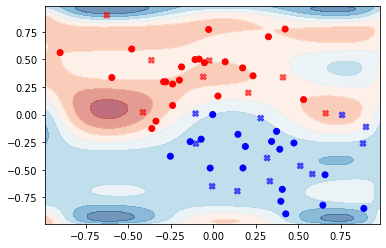

In [10]:
from matplotlib.colors import ListedColormap

xx, yy = np.meshgrid(np.arange(-0.99, 0.99, 0.01), np.arange(-0.99, 0.99, 0.01))

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

Z = clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.6)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, marker="X")